<a href="https://colab.research.google.com/github/simonkral1/Simon-Kral-Assignements/blob/main/GPT_2_Fine_Tuning_London_Reccomendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch.
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [ ]:
!pip install transformers

In [4]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
!nvidia-smi

Thu Nov 23 13:41:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [39]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, "'My Drive'","'london_data'")
filename = 'batch.csv'

drive.mount(gdrive_dir, force_remount=True)


Mounted at /content/gdrive/


In [8]:
# copy the data to the current Colab working directory
!cp $data_dir/$filename .

In [11]:
# load into a data frame
df = pd.read_csv ('batch.csv')
print(df)

                                                Prompt  \
0    Where can you enjoy panoramic views of London ...   
1      What theatrical experiences are must-sees in...   
2        Where can you get a breathtaking aerial vi...   
3        What can you do along the Thames that comb...   
4        Which art galleries in London offer the mo...   
..                                                 ...   
594                "What should I do in London today?"   
595       "Any suggestions for an activity in London?"   
596      "Looking for something to do in London, an...   
597      "What's a good thing to do in London right...   
598         "Can you recommend an activity in London?"   

                                              Response Unnamed: 2 Unnamed: 3  
0    Soak up the city views from Primrose Hill Now,...        NaN        NaN  
1    Experience the magic of a London is famous aro...        NaN        NaN  
2    Get a head for heights at the iconic Now, when...        NaN 

In [10]:
df.dropna(inplace=True) #remove NA values


We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

In [ ]:
doc_lengths = []

for prompt:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

SyntaxError: ignored

In [ ]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

TypeError: ignored

In [ ]:
np.average(doc_lengths)

491.45405405405404

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [12]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [13]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [14]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [15]:

# Concatenate 'Prompt' and 'Response'
qa_pairs = [prompt + " " + response for prompt, response in zip(df['Prompt'], df['Response'])]

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set the padding token. If your tokenizer does not have one, you can use the EOS token
tokenizer.pad_token = tokenizer.eos_token

# Create the dataset
dataset = GPT2Dataset(qa_pairs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))




  539 training samples
   60 validation samples


In [16]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [17]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [18]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [19]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [21]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [22]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    270. Loss: 0.6141396164894104.   Elapsed: 0:00:50.
0:  bipartisan,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    270. Loss: 0.7720555067062378.   Elapsed: 0:01:45.
0:  increasing|startoftext|>   "What should I do in London today?" Why not visit the London Park Zoo?The London Park Zoo is a world-renowned wildlife attraction in which Zoo's wildlife will pose unique challenges to explore, socialise and play in the zoo's world-famous enclosure for life. The Zoo is the home of the world-renowned Zoological Park Zoo, the largest and largest park in the world. Through Zoo, visitors will learn how the Zoo, Zoo exhibits and care facilities of the Zoo are designed to provide a space to inspire an exciting creative, innovative approach. The Zoo has an array of exhibitions, exhibits and scientific activities which attract large crowds and provide an innovative, social experience for visitors of all ages. The Zoo is well over a hundred years old, with the highest level of scientific education at our disposal and the Zoo exhibits its highest level of scientific education. The Zoo is highly

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    270. Loss: 0.4717424213886261.   Elapsed: 0:00:54.
0: day|startoftext|>What is the significance of the Royal College London's "Ticket Rules" and the London Transport Network?  The system of public transport which is currently under construction will be able to move forward under the new system. The system is planned to carry more people than anything else, with the aim of making London's roads more and more intelligent. Innovative innovation could come in the form of a new bus, an electric tube or a less-padded electric tube. But for now, the system will still need to be operated by staff rather than by cars.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    270. Loss: 0.16826829314231873.   Elapsed: 0:01:49.
0:  Hang|startoftext|>    "What's one thing to do in London?" Why not visit the Escape Rooms?Escape Rooms is an exciting London escape games game experience with some of the best ideas out there! Players will be locked inside a room, trying their luck and selecting the best escape story experience to offer. Experience the world of escape games in your hands while you solve puzzles and get out of the prison!

  Average training loss: 0.36
  Training epoch took: 0:02:27

Running Validation...
  Validation Loss: 0.34
  Validation took: 0:00:05

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    270. Loss: 0.11731325089931488.   Elapsed: 0:00:54.
0:  foods|startoftext|>What is a recommended historical abbey to visit in London? London's oldest royal cemetery, which opened to the public on October 2011. The British Museum is famous for its spectacular exhibits on the body and spirit of 16 royal queens, including one famous caterpillar and one famous foetus skeleton.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    270. Loss: 0.21676647663116455.   Elapsed: 0:01:49.
0:  trail|startoftext|>    "Can you recommend an activity in London?" Why not visit the Be At One Battersea Rise?We create a completely different vibe to our existing music venue with the absolute best music our hotel offers, brought to you by a team that brings their unparalleled attention to our venue and the ground in front of us. Our venue is 100% bespoke to the individual needs of the individual man and woman they call home. Everyone was fit to our venue during their concerts before booking and everyone was treated like a professional. It has an absolute ton of flexibility and all our seats are in our own private booth with the same BTU brand, same driver, same vibe, same vibe. No booking necessary and none of our clients are on a travel or executive trip with any of our shows or events. Just come and listen to us do what we do every day and enjoy the best night of our show. We pride ourselves on all things H

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    270. Loss: 0.14097371697425842.   Elapsed: 0:00:54.
0: intend|startoftext|>    "Any suggestions for an activity in London?" Why not visit the BAPS - BAPS - City?Take part in the BAPS - City Experience London - at the iconic and acclaimed BAPS - Farringdon station! We are a mix of Fabric and Gelato with a focus on creating truly unique, memorable and memorable branded experiences. Come experience our award-winning London experience with us in the Farringdon area of the West End. You'll also find BAPS - City Hall and surrounding areas, offering the best live music, comedy, theatre, music and entertainment in London.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    270. Loss: 0.1480703353881836.   Elapsed: 0:01:49.
0:  surround|startoftext|>    "What's one thing to do in London?" The Queen's Globe theatre is a recommended historic abbey for its historical significance and Poetâ€™s Corner is the setting for a truly unique and immersive experience.

  Average training loss: 0.10
  Training epoch took: 0:02:27

Running Validation...
  Validation Loss: 0.26
  Validation took: 0:00:05

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    270. Loss: 0.07637637853622437.   Elapsed: 0:00:54.
0:  reflex|startoftext|>    Where can you explore London's art scene in a variety of temporary venues? nan Now it should come as no shock to you dear reader that London recently has become home to some of the best museums in the world. From The National Gallery to the National Gallery, theres a whole host of intriguing temporary exhibitions in which to see, hear and frolic about all things art. From temporary exhibitions to permanent installations, theres plenty to see here, so book well in advance to see what takes your fancy and explore in a hurry.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    270. Loss: 0.03792911022901535.   Elapsed: 0:01:50.
0:  display|startoftext|>    "What's one thing to do in London?" Why not visit the Camden Town Transfer Service?Clue.co.uk offers London's most advanced and hassle-free way to transfer large parcels of parcels to and from any of the UK's major UK airports, UK cruise ports and beyond. We also offer fixed prices, with no hidden charges. We accept bank transfers, e-Transfers, MiniMoney, Mastercard, Discoveries and LiveLease.

  Average training loss: 0.06
  Training epoch took: 0:02:28

Running Validation...
  Validation Loss: 0.27
  Validation took: 0:00:05

Training complete!
Total training took 0:12:41 (h:mm:ss)


Let's view the summary of the training process.

In [25]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)


# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.84,0.43,0:02:25,0:00:05
2,0.36,0.34,0:02:27,0:00:05
3,0.20,0.28,0:02:29,0:00:05
4,0.10,0.26,0:02:27,0:00:05
5,0.06,0.27,0:02:28,0:00:05


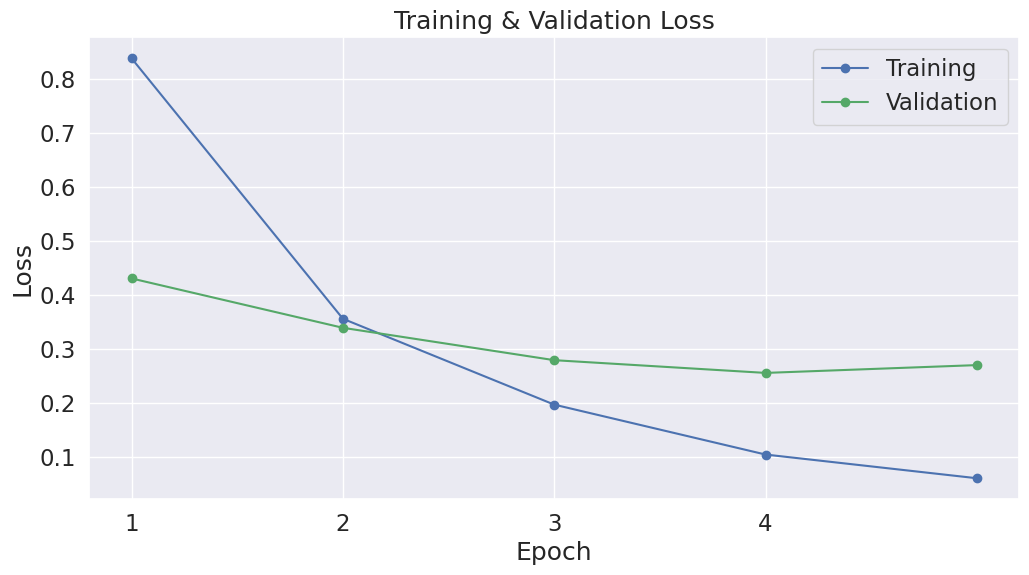

In [26]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [27]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [28]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [30]:
os.environ['LANG'] = 'en_US.UTF-8'
os.environ['LC_ALL'] = 'en_US.UTF-8'

In [32]:
# Directory you want to list
directory = './model_save/'

# List files and directories in the specified path
files = os.listdir(directory)

# Print the list of files and directories
for file in files:
    print(file)

config.json
generation_config.json
model.safetensors
special_tokens_map.json
vocab.json
tokenizer_config.json
merges.txt


In [31]:
!ls -l --block-size=K ./model_save/

NotImplementedError: ignored

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Aug 27 13:16 ./model_save/pytorch_model.bin


In [33]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

NotImplementedError: ignored

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
import os

gdrive_dir = '/content/drive'
print(os.listdir(gdrive_dir))


['Othercomputers', '.shortcut-targets-by-id', 'MyDrive', '.file-revisions-by-id', '.Trash-0']


In [45]:
import os
import shutil

# Google Drive directory
gdrive_dir = '/content/drive'

# Corrected path to your destination directory in Google Drive
data_dir = os.path.join(gdrive_dir, "MyDrive", "london_data")

# Define the source directory (where your model is saved)
source_dir = './model_save/'

# Ensure the destination directory does not already exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Copy the directory to the destination in Google Drive
for item in os.listdir(source_dir):
    s = os.path.join(source_dir, item)
    d = os.path.join(data_dir, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True) # dirs_exist_ok=True allows overwriting
    else:
        shutil.copy2(s, d)


# Generate Text

In [50]:
model.eval()

prompt = "what to do in london with a family?"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[10919,   284,   466,   287,   300,  3391,   351,   257,  1641,    30]],
       device='cuda:0')
0: what to do in london with a family? Find one of Londons Its been all the rage to open cocktail bars in the West End for the past two decades now, and while there are a whole ton of Harry Potter themed bars in the city, theres one in London where you can't beat the Warner Bros Studio Tour: The Making of Harry Potter, which starts here in a little over two weeks. Our top picks are: ÂThe Making of Harry Potter, Â“ an exhibition about the Making of Harry Potter, and the bars in between which you can drink cocktails.


1: what to do in london with a family?  A charmingly scruffy bakery that has been serving Londoners fresh bagels since 1977. Why go? Ah, the salt beef beigel (or bagel). It used to be a fixture on the Southbank, but nowadays you'll find it at The Brick Lane. It's a stomp around in crunchy autumn leaves followed by a warming tipple beside The Gherkin, a warming tipple b

These aren't bad at all!
